In [1]:
import numpy as np
import random
import heapq

In [24]:
class BallTreeNode:
    def __init__(self, points):
        self.points = points
        self.centroid = np.mean(points, axis=0)
        self.radius = max(np.linalg.norm(point - self.centroid) for point in points)
        self.left = None
        self.right = None

def find_farthest_point(points, point):
    distances = np.linalg.norm(points - point, axis=1)
    farthest_point_index = np.argmax(distances)
    return points[farthest_point_index]

def project_point_on_line(point, line_point1, line_point2):
    line_vec = line_point2 - line_point1
    point_vec = point - line_point1
    line_unit_vec = line_vec / np.linalg.norm(line_vec)
    projection_length = np.dot(point_vec, line_unit_vec)
    projection_vec = projection_length * line_unit_vec
    return projection_vec

def build_ball_tree(points, leaf_size):
    if len(points) <= leaf_size:
        return BallTreeNode(points)
    
    # Step 1: Select a random point
    random_point = random.choice(points)
    
    # Step 2: Find the point farthest from this random point
    farthest_point1 = find_farthest_point(points, random_point)
    
    # Step 3: Find the point farthest from the farthest point found in step 2
    farthest_point2 = find_farthest_point(points, farthest_point1)
    
    # Step 4: Project all points onto the line joining the two farthest points
    projections = np.array([np.dot(project_point_on_line(point, farthest_point1, farthest_point2), (farthest_point2 - farthest_point1)) for point in points])
    
    # Step 5: Use the median of the projections to divide the space into two halves
    median_projection = np.median(projections)
    left_points = points[projections <= median_projection]
    right_points = points[projections > median_projection]
    
    node = BallTreeNode(points)
    node.left = build_ball_tree(left_points, leaf_size)
    node.right = build_ball_tree(right_points, leaf_size)
    return node

def k_nearest_neighbors(node, query_point, k, heap=None):
    if heap is None:
        heap = []

    distance_to_centroid = np.linalg.norm(query_point - node.centroid)
    
    if len(heap) == k and distance_to_centroid - node.radius > -heap[0][0]:
        return heap

    if len(node.points) <= leaf_size:
        for point in node.points:
            distance = np.linalg.norm(query_point - point)
            if len(heap) < k:
                heapq.heappush(heap, (-distance, point))
            else:
                heapq.heappushpop(heap, (-distance, point))
        return heap

    children = [(node.left, np.linalg.norm(query_point - node.left.centroid)) if node.left else None,
                (node.right, np.linalg.norm(query_point - node.right.centroid)) if node.right else None]

    children = [child for child in children if child]
    children.sort(key=lambda x: x[1])

    for child, _ in children:
        heap = k_nearest_neighbors(child, query_point, k, heap)

    return heap


Nearest Neighbor: [(-0.4350320318912034, array([0.88219619, 0.86153614, 0.1370482 , 0.08467531, 0.92377708])), (-0.31491261044351815, array([0.35798052, 0.55626409, 0.24141939, 0.19525194, 0.92451489])), (-0.27956582652262646, array([0.63864982, 0.48588063, 0.25799185, 0.16123747, 0.83628923]))]
Distance: 0.4415824448943461


In [25]:
points = np.random.random((100, 5))  # 100 points in 5-dimensional space
leaf_size = 10
ball_tree = build_ball_tree(points, leaf_size)


Nearest Neighbor: [(-0.4594896830969757, array([0.39623431, 0.49273441, 0.49203345, 0.80637621, 0.43878691])), (-0.3037520013955922, array([0.30661622, 0.36119934, 0.04835943, 0.80377519, 0.1718769 ])), (-0.0844979567729755, array([0.3732119 , 0.46786106, 0.02237467, 0.70423499, 0.34840813]))]


In [39]:
query_point = np.random.random(5)
nearest_neighbor= k_nearest_neighbors(ball_tree, query_point, 3)

print("Nearest Neighbor:", nearest_neighbor)

Nearest Neighbor: [(-0.3752611121636694, array([0.79020633, 0.51326253, 0.57965742, 0.33507374, 0.78490357])), (-0.2615718494410685, array([0.92936146, 0.54867646, 0.77116878, 0.65519192, 0.62415929])), (-0.3626528023621662, array([0.80575685, 0.39624373, 0.36775322, 0.40021518, 0.48653814]))]


In [41]:
import time
import matplotlib.pyplot as plt

Build Time: 0.09126782417297363
Average Query Time: 0.0017105674743652345


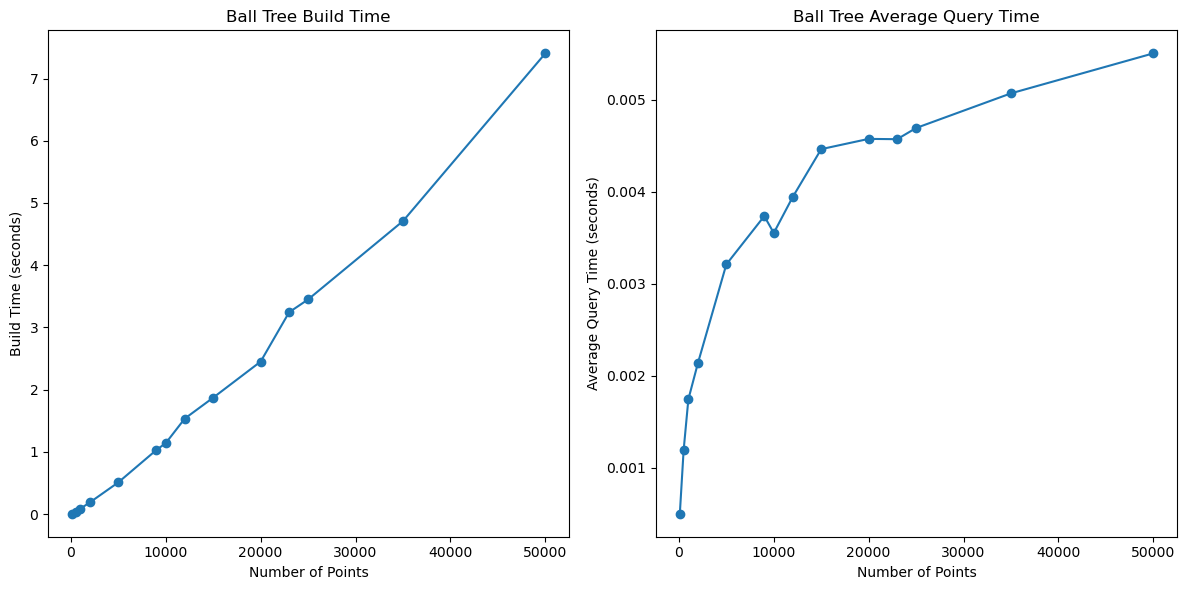

In [49]:
def benchmark_ball_tree(n_points, n_dims, leaf_size, n_queries, k):
    points = np.random.random((n_points, n_dims))
    query_points = np.random.random((n_queries, n_dims))
    
    start_time = time.time()
    ball_tree = build_ball_tree(points, leaf_size)
    build_time = time.time() - start_time
    
    query_times = []
    for query_point in query_points:
        start_time = time.time()
        neighbors_heap = k_nearest_neighbors(ball_tree, query_point, k)
        query_time = time.time() - start_time
        query_times.append(query_time)
    
    average_query_time = np.mean(query_times)
    
    return build_time, average_query_time

n_points = 1000
n_dims = 5
leaf_size = 10
n_queries = 100
k = 5

build_time, average_query_time = benchmark_ball_tree(n_points, n_dims, leaf_size, n_queries, k)

print("Build Time:", build_time)
print("Average Query Time:", average_query_time)

# Visualize
n_points_list = [100, 500, 1000, 2000, 5000, 9000, 10000, 12000, 15000, 20000, 23000, 25000, 35000, 50000]
build_times = []
average_query_times = []

for n_points in n_points_list:
    build_time, average_query_time = benchmark_ball_tree(n_points, n_dims, leaf_size, n_queries, k)
    build_times.append(build_time)
    average_query_times.append(average_query_time)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(n_points_list, build_times, marker='o')
plt.title('Ball Tree Build Time')
plt.xlabel('Number of Points')
plt.ylabel('Build Time (seconds)')

plt.subplot(1, 2, 2)
plt.plot(n_points_list, average_query_times, marker='o')
plt.title('Ball Tree Average Query Time')
plt.xlabel('Number of Points')
plt.ylabel('Average Query Time (seconds)')

plt.tight_layout()
plt.show()

In [46]:
def naive_k_nearest_neighbors(points, query_point, k):
    distances = np.linalg.norm(points - query_point, axis=1)
    nearest_indices = np.argsort(distances)[:k]
    return points[nearest_indices]

def accuracy_measure(ball_tree, points, query_points, k):
    correct_matches = 0
    total_queries = len(query_points)

    for query_point in query_points:
        # neighbors will BallTree
        ball_tree_heap = k_nearest_neighbors(ball_tree, query_point, k)
        ball_tree_neighbors = [point for _, point in ball_tree_heap]

        # neighbors with naive search
        naive_neighbors = naive_k_nearest_neighbors(points, query_point, k)

        ball_tree_set = set(tuple(neighbor) for neighbor in ball_tree_neighbors)
        naive_set = set(tuple(neighbor) for neighbor in naive_neighbors)
        correct_matches += len(ball_tree_set.intersection(naive_set))
    
    accuracy = correct_matches / (total_queries * k)
    return accuracy


In [48]:
points = np.random.random((n_points, n_dims))
query_points = np.random.random((n_queries, n_dims))
ball_tree = build_ball_tree(points, leaf_size)

accuracy = accuracy_measure(ball_tree, points, query_points, k)
print("Accuracy:", accuracy)

Accuracy: 1.0
